
--- Evaluasi Model ---
              precision    recall  f1-score   support

     Agung P       0.65      0.52      0.58        21
      Dedi Y       0.52      0.52      0.52        27
      Harion       0.88      0.88      0.88        25
     Saikhun       0.55      0.63      0.59        27

    accuracy                           0.64       100
   macro avg       0.65      0.64      0.64       100
weighted avg       0.64      0.64      0.64       100


Top-3 Accuracy: 0.93

--- Rekomendasi Teknisi Top-3 (contoh) ---
     Top 1    Top 2    Top 3 Actual Teknisi
0   Harion   Dedi Y  Saikhun         Harion
1   Harion  Agung P  Saikhun         Harion
2  Saikhun  Agung P   Harion         Dedi Y
3   Dedi Y  Agung P  Saikhun        Saikhun
4   Dedi Y  Saikhun   Harion         Dedi Y
5   Harion   Dedi Y  Saikhun         Harion
6   Dedi Y  Saikhun  Agung P         Dedi Y
7   Dedi Y  Saikhun  Agung P        Saikhun
8  Saikhun   Dedi Y  Agung P        Agung P
9  Agung P  Saikhun   Harion       

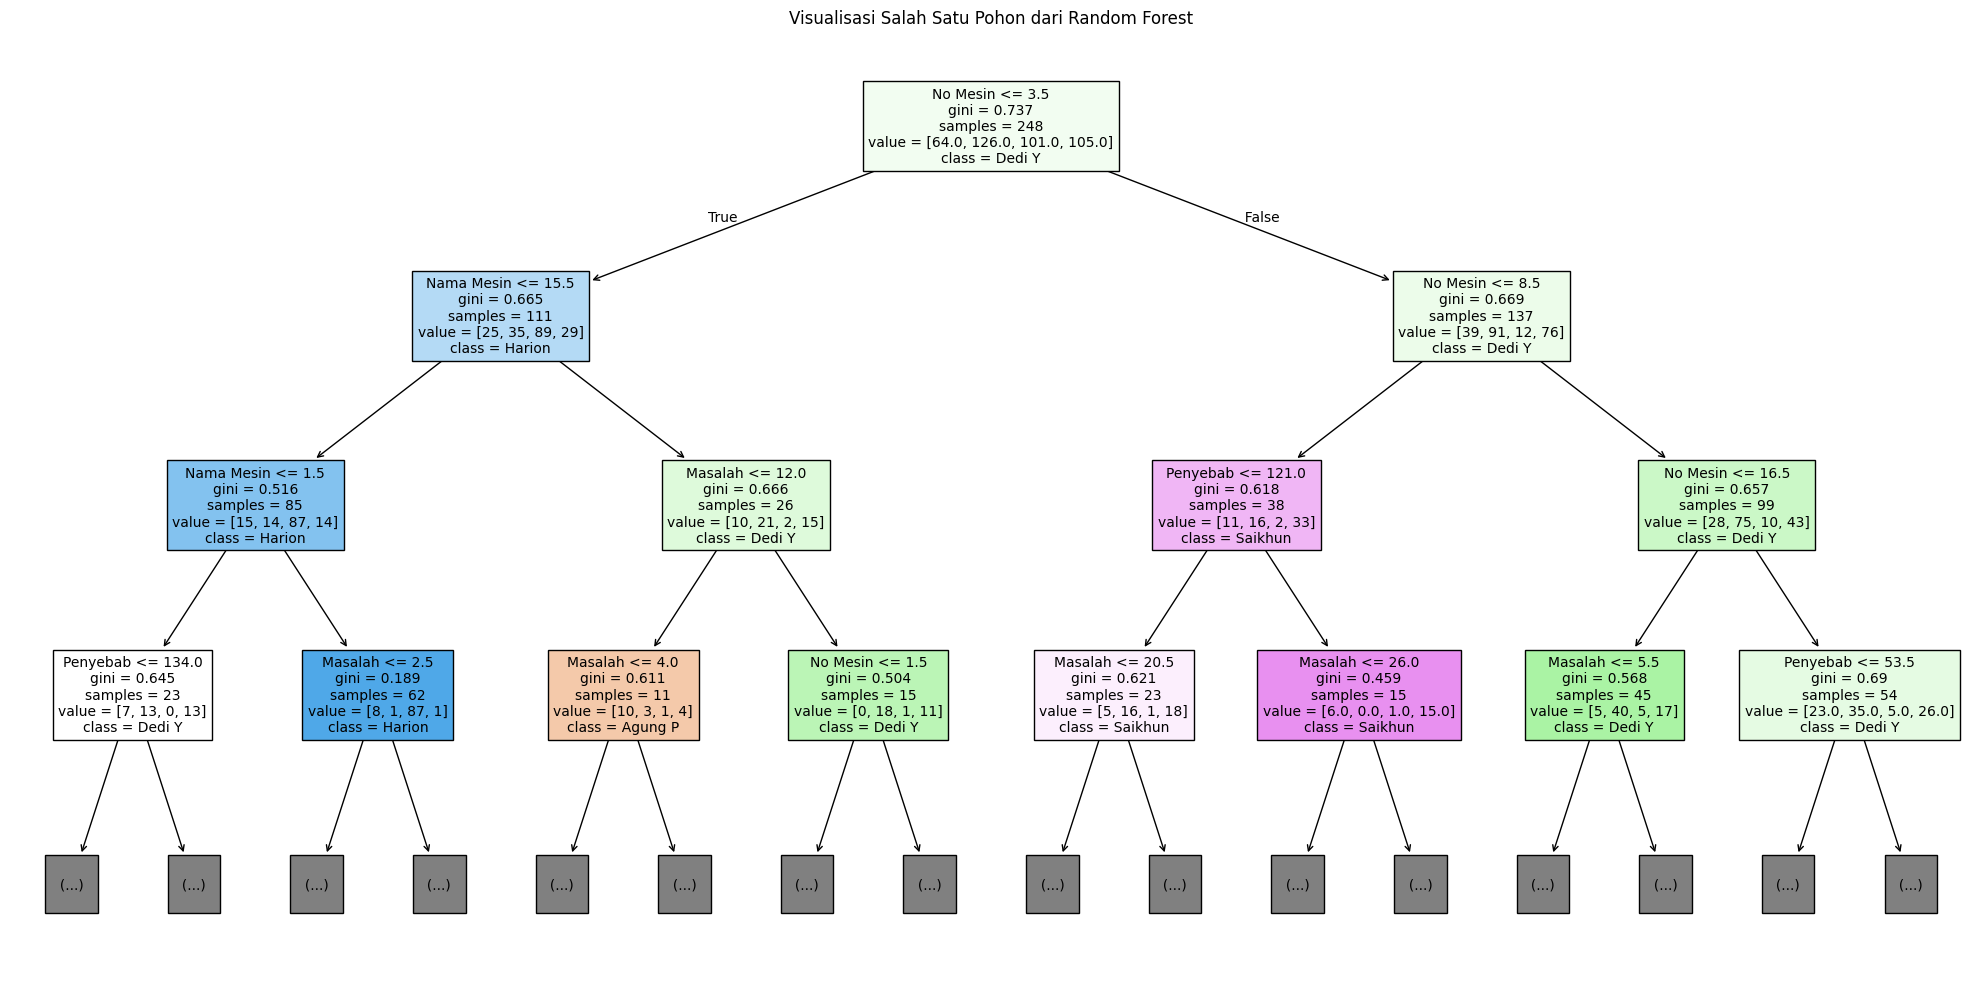

In [1]:
# ===========================================
# 1. IMPORT LIBRARY
# ===========================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, top_k_accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import joblib

# ===========================================
# 2. LOAD & PERSIAPAN DATA
# ===========================================
df = pd.read_excel("Pemodelan_DB.xlsx")

# ambil kolom yang relevan
df = df[['Nama Mesin', 'No Mesin', 'Masalah', 'Penyebab', 'Nama Teknisi', 'Durasi Pengerjaan']].dropna()

# ===========================================
# 3. ENCODING TARGET (TEKNISI)
# ===========================================
le_target = LabelEncoder()
df['Teknisi_enc'] = le_target.fit_transform(df['Nama Teknisi'])

# ===========================================
# 4. ENCODING FITUR KATEGORIKAL
# ===========================================
X = df[['Nama Mesin', 'No Mesin', 'Masalah', 'Penyebab']]
X_encoded = X.apply(LabelEncoder().fit_transform)
y = df['Teknisi_enc']

# ===========================================
# 5. SPLIT DATA (TRAIN & TEST)
# ===========================================
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, stratify=y, 
                                                    test_size=0.2, random_state=42)

# ===========================================
# 6. TRAINING MODEL (Random Forest) DENGAN GRID SEARCH
# ===========================================
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# ===========================================
# 7. EVALUASI MODEL
# ===========================================
y_pred = best_model.predict(X_test)
print("\n--- Evaluasi Model ---")
print(classification_report(
    y_test,
    y_pred,
    labels=np.unique(y_pred),
    target_names=le_target.inverse_transform(np.unique(y_pred))
))

# ===========================================
# 8. TOP-3 PREDIKSI TEKNISI
# ===========================================
y_proba = best_model.predict_proba(X_test)
top3_accuracy = top_k_accuracy_score(
    y_test, y_proba, k=3, labels=range(len(le_target.classes_))
)
print(f"\nTop-3 Accuracy: {top3_accuracy:.2f}")

# ===========================================
# 9. REKOMENDASI TOP-3 TEKNISI
# ===========================================
top3_indices = np.argsort(y_proba, axis=1)[:, -3:][:, ::-1]
top3_names = [[le_target.classes_[i] for i in row] for row in top3_indices]
df_top3 = pd.DataFrame(top3_names, columns=["Top 1", "Top 2", "Top 3"])
df_top3["Actual Teknisi"] = le_target.inverse_transform(y_test[:len(df_top3)])
print("\n--- Rekomendasi Teknisi Top-3 (contoh) ---")
print(df_top3.head(10))

# ===========================================
# 10. VISUALISASI SALAH SATU POHON KEPUTUSAN
# ===========================================
plt.figure(figsize=(20, 10))
plot_tree(
    best_model.estimators_[0],
    feature_names=X.columns,
    class_names=le_target.classes_,
    filled=True,
    max_depth=3,
    fontsize=10
)
plt.title("Visualisasi Salah Satu Pohon dari Random Forest")
plt.tight_layout()
plt.show()

# ===========================================
# 11. SIMPAN MODEL
# ===========================================
# joblib.dump(best_model, "model_teknisi_rf.joblib")
# joblib.dump(le_target, "label_encoder_target.pkl")
